# From Text to Visualization: A Complete Data Preparation Pipeline

This notebook demonstrates the complete process of preparing text data for visualization as a scatter plot. We'll use the [WildChat Dataset](https://wildchat.allen.ai/) as our example, but the principles apply to any text corpus.

## Overview: The Visualization Data Pipeline

To visualize text as points in 2D space, we need to transform high-dimensional semantic information into a format suitable for plotting. Here's the general flow:

```
Raw Text Data
    ↓
1. SEGMENTATION: Break into meaningful chunks
    ↓
2. EMBEDDING: Convert text to high-dimensional vectors (e.g., 1536 dimensions)
    ↓
3. PLANARIZATION: Reduce to 2D while preserving semantic relationships
    ↓
4. CLUSTERING (Optional): Group similar points for color coding
    ↓
Visualization-Ready Data (x, y, color, size, metadata)
```

### Why This Approach?

- **Embeddings capture semantic meaning**: Similar text segments will have similar embeddings
- **Dimensionality reduction preserves structure**: UMAP, t-SNE, and other methods maintain the "closeness" of semantically related items
- **Visual exploration becomes intuitive**: Similar concepts cluster together in 2D space

### Dataset: WildChat

WildChat is a corpus of ~1M conversations with ChatGPT collected in the wild. Each conversation contains:
- Multiple turns (user asks, assistant responds)
- Metadata (language, toxicity scores, timestamps)
- Nested structure that needs flattening

**Special considerations for this dataset:**
- Conversations are nested lists of dictionaries → we'll expand them into individual turns
- Multiple languages present → we'll filter to English for consistency
- Token limits for embeddings → we'll validate and filter segments
- Large volume → we'll work with a subset for this demo

## Setup and Imports

In [ ]:
# Standard data science toolkit
import pandas as pd
import numpy as np
from collections import Counter

# Hugging Face datasets
from datasets import load_dataset

# Embedding and planarization tools from imbed
from imbed.util import planar_embeddings, planar_embeddings_dict_to_df

# OpenAI embeddings (via oa package)
import oa

# Clustering
from sklearn.cluster import KMeans
from imbed.data_prep import kmeans_cluster_indices

# For token validation
from imbed.base import add_token_info_to_df

# Visualization (for final check)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## Step 1: Load and Explore Raw Data

First, let's load the WildChat dataset from HuggingFace. We'll start with a small subset to understand the structure.

In [ ]:
# For full processing, set streaming=False
dataset = load_dataset(
    "allenai/WildChat-1M", 
    split="train",
    streaming=True
)

In [4]:
# Load a subset of the data (streaming to avoid downloading everything)

N_CONVERSATIONS = 1000  # Set to None to load full dataset

if N_CONVERSATIONS:
    raw_data = pd.DataFrame(list(dataset.take(N_CONVERSATIONS)))

else:
    print("!!Loading full dataset into memory (This can take A LOT OF RAM, and time to load)...")
    print("!!Loading took XXX on my computer")
    # 1. Convert the Hugging Face Dataset to a generator of pandas DataFrames (your current step)
    raw_data_generator = dataset.to_pandas()

    # 2. Convert the generator into a list of DataFrames and then concatenate them
    # This collects all the chunks produced by the generator into one final DataFrame.
    raw_data = pd.concat(list(raw_data_generator))

print(f"Loaded {len(raw_data)} conversations.")
print(f"Columns: {raw_data.columns.tolist()}")
print(f"\nShape: {raw_data.shape}")
print("First row looks like this:")
print(raw_data.iloc[0])

Loaded 1000 conversations.
Columns: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']

Shape: (1000, 14)
First row looks like this:
conversation_hash                       c9ec5b440fbdd2a269333dd241f32f64
model                                                         gpt-4-0314
timestamp                                      2023-04-09 00:02:53+00:00
conversation           [{'content': 'Hey there! Are you familiar with...
turn                                                                   1
language                                                         English
openai_moderation      [{'categories': {'harassment': False, 'harassm...
detoxify_moderation    [{'identity_attack': 0.00020589135237969458, '...
toxic                                                              False
redacted                                                           False


Here you should probably first have a look at the structure of the data, it's contents, etc.
Maybe you want to only take some particular categories (like one particular language, in a time range, etc.)
That's on you. Do what you need to do to filter in what you want. 

The only dependency here is that:
* You call the result "raw_data"
* You don't remove the columns (especially the "conversation" one)

In [ ]:
# Do more filtering here...


In [5]:
# Peep at your data again
print(f"Columns: {raw_data.columns.tolist()}")
print(f"\nShape: {raw_data.shape}")
print("First row looks like this:")
print(raw_data.iloc[0])

Columns: ['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header']

Shape: (1000, 14)
First row looks like this:
conversation_hash                       c9ec5b440fbdd2a269333dd241f32f64
model                                                         gpt-4-0314
timestamp                                      2023-04-09 00:02:53+00:00
conversation           [{'content': 'Hey there! Are you familiar with...
turn                                                                   1
language                                                         English
openai_moderation      [{'categories': {'harassment': False, 'harassm...
detoxify_moderation    [{'identity_attack': 0.00020589135237969458, '...
toxic                                                              False
redacted                                                           False
state                      

In [ ]:
# Look at what a conversation looks like
sample_conversation = raw_data.iloc[0]['conversation']
print(f"This conversation contains {len(sample_conversation)} turns (some contain more)")
print(f"\nFirst turn: {sample_conversation[0]}")
print(f"\nSecond turn: {sample_conversation[1]}")

A conversation contains 2 turns

First turn: {'content': 'Hey there! Are you familiar with reality shifting? So, I’m refining a foolproof method for reality shifting and want to pick a destination. Want to help me? I’m thinking something pretty personalized. There are a few things that are required of my destination. 1. The quest. I have to have a clear overarching goal in my reality, and don’t make it too crazy. It should be more along the lines of “save the president’s daughter” or “escape this weird wacky sinister place” NOT “get an artifact that literally controls reality”. Seriously, don’t make me fetch an artifact, or fetch anything. Instead, make me DO something. 2. Babes. I need pretty girls. 3. The entry. I need to get to lose consciousness in order to begin my journey in my desired reality, preferably by having it knocked out by one of the aforementioned babes. 4. Action. It needs to be cool. 5. Unconsciousness. Myself and the babes need to pass out in this place, preferably 

## Step 2: Segment the Data - Expand Nested Structure

### Why We Need This Step (WildChat-Specific)

The raw WildChat data has **nested lists and dictionaries**:
- `conversation`: List of dicts, each with 'role' and 'content'
- `openai_moderation`: List of moderation results per turn
- `detoxify_moderation`: List of toxicity scores per turn

**Goal:** Flatten this into one row per conversation turn, where each turn is a segment we can embed.

### General Principle

For any text corpus, you need to decide on your **segmentation strategy**:
- Whole documents (if short)
- Paragraphs
- Sentences  
- Fixed-size chunks (e.g., 512 tokens)
- Semantic chunks (e.g., by topic)

Choose based on:
- What granularity makes sense for your analysis
- Embedding model token limits
- Computational resources

In [ ]:
def expand_wildchat_data(df):
    """
    Expand the nested structure of WildChat data.
    
    The 'conversation', 'openai_moderation', and 'detoxify_moderation' columns
    contain aligned lists - each item corresponds to one turn of the conversation.
    
    This function:
    1. Expands rows: Creates one row per conversation turn
    2. Expands columns: Flattens nested dicts into separate columns
    3. Cleans: Removes null moderation data and duplicate columns
    
    Returns:
        DataFrame where each row is a single conversation turn with its metadata
    """

    # For data manipulation
    from tabled import expand_rows, expand_columns
    
    print(f"Starting with {len(df)} conversations...")
    
    # Step 1: Expand rows - one row per conversation turn
    df = expand_rows(
        df, 
        ['conversation', 'openai_moderation', 'detoxify_moderation']
    )
    print(f"After row expansion: {len(df)} turns")
    
    # Step 2: Expand columns - flatten the dict fields
    df = expand_columns(
        df, 
        ['conversation', 'openai_moderation', 'detoxify_moderation']
    )
    
    # Step 3: Handle OpenAI moderation nested structure
    openai_moderation_cols = [
        'openai_moderation.categories',
        'openai_moderation.category_scores',
    ]
    
    # Some rows have null moderation - drop them
    n_before = len(df)
    df = df.dropna(subset=openai_moderation_cols)
    print(f"Dropped {n_before - len(df)} rows with null moderation data")
    
    # Expand the remaining moderation fields
    df = expand_columns(df, openai_moderation_cols)
    
    # Step 4: Clean up duplicate columns (indicated by '/' in name)
    df = df[[c for c in df.columns if '/' not in c]]
    
    print(f"Final: {len(df)} rows with {len(df.columns)} columns")
    return df

In [6]:
# Apply the expansion
expanded_df = expand_wildchat_data(raw_data.copy())
expanded_df.head()

Starting with 1000 conversations...
After row expansion: 5534 turns
Dropped 20 rows with null moderation data
Final: 5514 rows with 54 columns


,conversation_hash,model,timestamp,turn,language,toxic,redacted,state,country,hashed_ip,...,openai_moderation.category_scores.hate,openai_moderation.category_scores.hate_threatening,openai_moderation.category_scores.self-harm,openai_moderation.category_scores.self_harm,openai_moderation.category_scores.self_harm_instructions,openai_moderation.category_scores.self_harm_intent,openai_moderation.category_scores.sexual,openai_moderation.category_scores.sexual_minors,openai_moderation.category_scores.violence,openai_moderation.category_scores.violence_graphic
0,c9ec5b440fbdd2a269333dd241f32f64,gpt-4-0314,2023-04-09 00:02:53+00:00,1,English,False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,...,0.000457,1.314140e-05,0.000055,0.000055,1.166682e-06,1.481169e-05,0.006505,0.000202,0.083071,0.000052
1,c9ec5b440fbdd2a269333dd241f32f64,gpt-4-0314,2023-04-09 00:02:53+00:00,1,English,False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,...,0.000029,7.789909e-07,0.000005,0.000005,1.956341e-07,4.521183e-07,0.001418,0.000008,0.050996,0.000143
2,34f1581760df304d539e2fe4653b40d3,gpt-4-0314,2023-04-09 00:03:20+00:00,2,Spanish,False,False,A Coruña,Spain,58369722cd0bdf7fc027a67491ba65b74576df6994c36c...,...,0.000386,1.414197e-04,0.000266,0.000266,1.878071e-04,2.400743e-05,0.064903,0.000058,0.000780,0.000021
3,34f1581760df304d539e2fe4653b40d3,gpt-4-0314,2023-04-09 00:03:20+00:00,2,Spanish,False,False,A Coruña,Spain,58369722cd0bdf7fc027a67491ba65b74576df6994c36c...,...,0.000027,3.532838e-05,0.000257,0.000257,3.903395e-06,1.878252e-06,0.070757,0.000466,0.000582,0.000079
4,34f1581760df304d539e2fe4653b40d3,gpt-4-0314,2023-04-09 00:03:20+00:00,2,Spanish,False,False,A Coruña,Spain,58369722cd0bdf7fc027a67491ba65b74576df6994c36c...,...,0.000046,1.121400e-04,0.000082,0.000082,3.227422e-05,2.028088e-04,0.000722,0.000496,0.000287,0.000580


In [7]:
# Check key columns we'll use
print("Key columns for analysis:")
key_cols = ['conversation.content', 'conversation.role', 'language', 'conversation_hash']
print(expanded_df[key_cols].head())

Key columns for analysis:
                                conversation.content conversation.role  \
0  Hey there! Are you familiar with reality shift...              user   
1  Hey there! I'm more than happy to help you pla...         assistant   
2  Crea una imagen de una mujer corriente por la ...              user   
3  Como inteligencia artificial basada en texto, ...         assistant   
4  Aceede a Amazon y dame una lista de lo TV más ...              user   

  language                 conversation_hash  
0  English  c9ec5b440fbdd2a269333dd241f32f64  
1  English  c9ec5b440fbdd2a269333dd241f32f64  
2  Spanish  34f1581760df304d539e2fe4653b40d3  
3  Spanish  34f1581760df304d539e2fe4653b40d3  
4  Spanish  34f1581760df304d539e2fe4653b40d3  


In [8]:
# Language distribution
print("\nLanguage distribution in our sample:")
print(expanded_df['language'].value_counts().head(10))


Language distribution in our sample:
language
English     2751
Chinese     1254
Russian      384
Korean       382
French       138
Spanish      126
Italian      112
German        48
Japanese      30
Turkish       28
Name: count, dtype: int64


## Step 3: Filter and Prepare Segments

### General Principle

Before computing embeddings, **filter and validate** your segments:
- Remove empty or too-short segments
- Filter by language (if relevant)
- Validate token counts are within limits
- Remove or handle duplicates

### WildChat-Specific Decisions

1. **Language filtering**: English only (for consistency)
2. **Token validation**: OpenAI models have token limits
3. **Conversation integrity**: Keep only conversations where ALL turns are valid

In [9]:
# Filter to English conversations
english_df = expanded_df[expanded_df['language'] == 'English'].copy()
print(f"After English filter: {len(english_df)} turns")

# Add an ID column for tracking
english_df['segment_id'] = english_df.index.values

# Add segment length (character count)
english_df['segment_length'] = english_df['conversation.content'].apply(len)

print(f"\nSegment length statistics:")
print(english_df['segment_length'].describe())

After English filter: 2751 turns

Segment length statistics:
count     2751.000000
mean      1326.826972
std       2908.020562
min          1.000000
25%         90.500000
50%        493.000000
75%       1651.000000
max      37447.000000
Name: segment_length, dtype: float64


In [10]:
# Validate tokens and filter invalid segments
# This adds columns: n_tokens, segment_is_valid, not_valid_reason
print("Validating token counts...")
validated_df = add_token_info_to_df(
    english_df,
    segments_col='conversation.content',
    model='text-embedding-3-small'  # The embedding model we'll use
)

print(f"\nValid segments: {validated_df['segment_is_valid'].sum()}")
print(f"Invalid segments: {(~validated_df['segment_is_valid']).sum()}")

Validating token counts...

Valid segments: 2751
Invalid segments: 0


In [12]:
# Keep only conversations where ALL turns are valid
# This ensures we don't break conversation context
embeddable_df = validated_df.groupby('conversation_hash').filter(
    lambda x: x['segment_is_valid'].all()
)

print(f"After filtering for complete valid conversations: {len(embeddable_df)} turns")
print(f"From {embeddable_df['conversation_hash'].nunique()} complete conversations")

After filtering for complete valid conversations: 2751 turns
From 523 complete conversations


## Step 4: Compute Embeddings

### What Are Embeddings?

Embeddings are **dense vector representations** of text that capture semantic meaning. Text with similar meanings will have similar embeddings (measured by cosine similarity or Euclidean distance).

### General Options

- **OpenAI API** (text-embedding-3-small/large): High quality, paid
- **Sentence Transformers** (all-MiniLM, all-mpnet): Good quality, free, local
- **Word2Vec, GloVe**: Classic approaches, less contextual
- **Custom models**: Fine-tuned for your domain

### For This Demo

We'll use **OpenAI's text-embedding-3-small** (1536 dimensions):
- High quality semantic capture
- Easy to use via `oa` package
- Reasonable cost

**Note:** In production, consider batching for efficiency and cost management.

In [13]:
# For this demo, let's work with a smaller subset to avoid API costs
# In production, you'd batch process the full dataset
DEMO_SIZE = 200  # Number of segments to embed

demo_df = embeddable_df.head(DEMO_SIZE).copy()
print(f"Computing embeddings for {len(demo_df)} segments...")

Computing embeddings for 200 segments...


In [14]:
def compute_embeddings_for_segments(segments, model='text-embedding-3-small', batch_size=100):
    """
    Compute embeddings for a list of text segments.
    
    Args:
        segments: List of text strings
        model: OpenAI embedding model to use
        batch_size: Number of segments to process at once
        
    Returns:
        List of embedding vectors (each is a list of floats)
    """
    embeddings = []
    
    # Process in batches for efficiency
    for i in range(0, len(segments), batch_size):
        batch = segments[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}: segments {i} to {i+len(batch)}")
        
        # Get embeddings from OpenAI
        # The oa package handles the API call details
        batch_embeddings = oa.embeddings(
            batch, 
            model=model,
            # Add any other parameters you need
        )
        
        embeddings.extend(batch_embeddings)
    
    return embeddings

In [17]:
MOCK_EMBEDDINGS = False  # Set to True to use mock embeddings for testing

# Extract the text segments
segments = demo_df['conversation.content'].tolist()

if not MOCK_EMBEDDINGS:
    embeddings = compute_embeddings_for_segments(segments)

    print(f"\nComputed {len(embeddings)} (REAL) embeddings")
else:
    # For testing without API calls, you can use this mock:
    print("Using mock embeddings for demo (replace with real API call)")
    embeddings = [np.random.randn(1536).tolist() for _ in range(len(segments))]
    print(f"\nComputed {len(embeddings)} embeddings")

print(f"Each embedding has {len(embeddings[0])} dimensions")

Processing batch 1: segments 0 to 100
Processing batch 2: segments 100 to 200

Computed 200 (REAL) embeddings
Each embedding has 1536 dimensions


In [18]:
# Add embeddings to our dataframe
demo_df['embedding'] = embeddings

# Verify
print(f"DataFrame now has {len(demo_df.columns)} columns")
print(f"Including 'embedding' column: {'embedding' in demo_df.columns}")

DataFrame now has 59 columns
Including 'embedding' column: True


## Step 5: Planarization - Dimensionality Reduction

### Why Planarization?

Our embeddings are in **1536-dimensional space**. We need to project them to **2D** for visualization while preserving the semantic structure as much as possible.

### Common Methods

| Method | Pros | Cons | Best For |
|--------|------|------|----------|
| **PCA** | Fast, deterministic, global structure | Linear, may lose local structure | Quick exploration, linear patterns |
| **t-SNE** | Excellent local structure, reveals clusters | Slow, non-deterministic, distorts global | Cluster discovery |
| **UMAP** | Balanced local/global, faster than t-SNE | Requires tuning | General purpose, best of both worlds |
| **MDS** | Preserves distances | Slow for large datasets | When exact distances matter |

### For This Demo

We'll compute **multiple planarizations** so you can choose the best one for your visualization:
1. UMAP (recommended for most cases)
2. t-SNE (for comparison)
3. PCA (for baseline)

The `imbed.util.planar_embeddings` function provides a unified interface to all these methods.

In [19]:
# Extract embedding vectors as a numpy array
# Important: Use list() conversion, not just .to_numpy()
embedding_vectors = np.array(demo_df['embedding'].to_list())

print(f"Embedding matrix shape: {embedding_vectors.shape}")
print(f"({len(demo_df)} segments × 1536 dimensions)")

Embedding matrix shape: (200, 1536)
(200 segments × 1536 dimensions)


### Option 1: UMAP (Recommended)

UMAP (Uniform Manifold Approximation and Projection) balances local and global structure preservation.

In [22]:
# Compute UMAP projection
print("Computing UMAP projection...")
umap_result = planar_embeddings(
    embedding_vectors,
    # you can use your own function, or a supported function key 
    # (if you have the necessary backend installed)
    embeddings_func='umap',  
)

print(f"UMAP result type: {type(umap_result)}")
print(f"Keys: {umap_result.keys()}")

Computing UMAP projection...
UMAP result type: <class 'dict'>
Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])


In [26]:
umap_df.head()

,x,y
id_,,
0,23.231699,-0.276132
1,22.657951,-0.697300
2,16.547266,2.398446
3,16.597704,2.538037
4,23.221348,-0.253659


In [25]:
# Convert to DataFrame with nice column names
umap_df = planar_embeddings_dict_to_df(umap_result)

# Add to our main dataframe
demo_df['x_umap'] = umap_df['x']
demo_df['y_umap'] = umap_df['y']

print("UMAP coordinates added!")
print(demo_df[['x_umap', 'y_umap']].describe())

UMAP coordinates added!
           x_umap      y_umap
count  114.000000  114.000000
mean    17.849018    4.001224
std      5.807818    5.694846
min      3.667367   -2.163567
25%     16.977821    0.146862
50%     20.039814    2.691971
75%     21.252533    4.263669
max     23.345713   17.452740


### Option 2: t-SNE

t-SNE excels at revealing clusters but can be slow and distorts global structure.

In [29]:

# Compute t-SNE projection
print("Computing t-SNE projection...")
tsne_result = planar_embeddings(
    embedding_vectors,
    embeddings_func='tsne',
)

tsne_df = planar_embeddings_dict_to_df(tsne_result)
demo_df['x_tsne'] = tsne_df['x']
demo_df['y_tsne'] = tsne_df['y']

print("t-SNE coordinates added!")

Computing t-SNE projection...
t-SNE coordinates added!


### Option 3: PCA (Baseline)

PCA is fast and deterministic, good for a quick first look.

In [31]:
from sklearn.decomposition import PCA

# Compute PCA projection
print("Computing PCA projection...")
pca_result = planar_embeddings(
    embedding_vectors,
    embeddings_func=PCA(n_components=2).fit_transform,
)

pca_df = planar_embeddings_dict_to_df(pca_result)
demo_df['x_pca'] = pca_df['x']
demo_df['y_pca'] = pca_df['y']

print("PCA coordinates added!")

Computing PCA projection...
PCA coordinates added!


### Quick Visual Comparison

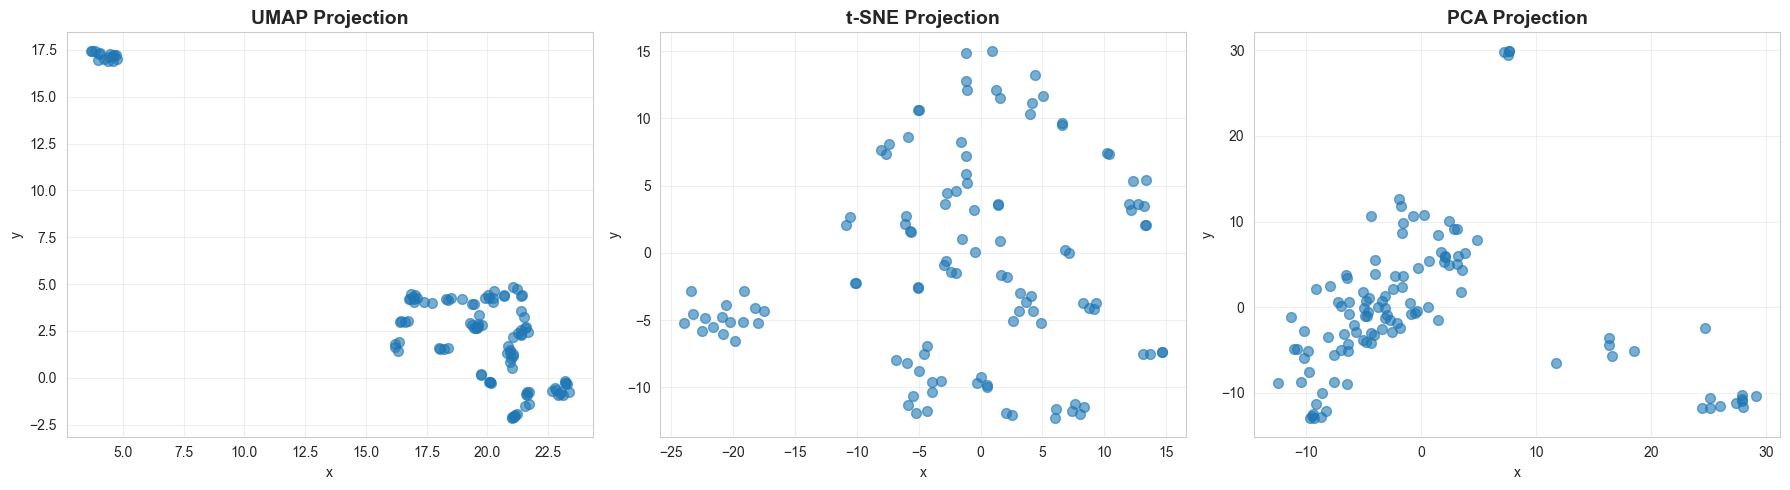


💡 Tip: UMAP typically provides the best balance of local and global structure.


In [32]:
# Compare the three methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    ('UMAP', 'x_umap', 'y_umap'),
    ('t-SNE', 'x_tsne', 'y_tsne'),
    ('PCA', 'x_pca', 'y_pca')
]

for ax, (name, x_col, y_col) in zip(axes, methods):
    ax.scatter(
        demo_df[x_col], 
        demo_df[y_col],
        alpha=0.6,
        s=50
    )
    ax.set_title(f'{name} Projection', fontsize=14, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Tip: UMAP typically provides the best balance of local and global structure.")

### Or with cosmograph (recommended)

In [35]:
# have a peep at the columns to know what to choose from
demo_df.columns

Index(['conversation_hash', 'model', 'timestamp', 'turn', 'language', 'toxic',
       'redacted', 'state', 'country', 'hashed_ip', 'header',
       'conversation.content', 'conversation.country',
       'conversation.hashed_ip', 'conversation.header',
       'conversation.language', 'conversation.redacted', 'conversation.role',
       'conversation.state', 'conversation.timestamp', 'conversation.toxic',
       'conversation.turn_identifier', 'openai_moderation.flagged',
       'detoxify_moderation.identity_attack', 'detoxify_moderation.insult',
       'detoxify_moderation.obscene', 'detoxify_moderation.severe_toxicity',
       'detoxify_moderation.sexual_explicit', 'detoxify_moderation.threat',
       'detoxify_moderation.toxicity',
       'openai_moderation.categories.harassment',
       'openai_moderation.categories.harassment_threatening',
       'openai_moderation.categories.hate',
       'openai_moderation.categories.hate_threatening',
       'openai_moderation.categories.self-har

In [ ]:
from cosmograph import cosmo 

g1 = cosmo(
    demo_df,
    point_x_by='x_umap',
    point_y_by='y_umap',
    point_label_by='conversation.content',
    point_color_by='conversation.role',
)
g1


Cosmograph(background_color=None, components_display_state_mode=None, focused_point_ring_color=None, hovered_p…

## Step 6: Clustering (Optional)

### Why Cluster?

Clustering helps:
- **Assign colors** to groups of similar items in visualization
- **Discover patterns** in your data
- **Summarize** large datasets by examining cluster centroids

### General Approach

Cluster the **original high-dimensional embeddings**, not the 2D projections:
- 2D projections lose information
- Clustering in the original space is more accurate
- Then assign cluster colors to the 2D points

### Common Methods

- **K-Means**: Simple, fast, requires specifying k
- **HDBSCAN**: Finds clusters automatically, handles noise
- **Hierarchical**: Creates a dendrogram, can choose granularity

### For This Demo

We'll use **K-Means** with multiple k values to see different granularities.

In [39]:
# Cluster at different granularities
cluster_configs = [5, 8, 13]  # Number of clusters to try

print("Computing clusters...")
for n_clusters in cluster_configs:
    print(f"  - {n_clusters} clusters")
    
    # Use the imbed utility function
    cluster_labels = kmeans_cluster_indices(
        embedding_vectors,
        n_clusters=n_clusters
    )
    
    # Add to dataframe
    col_name = f'cluster_{n_clusters:02d}'
    demo_df[col_name] = cluster_labels

print("\nClustering complete!")

Computing clusters...
  - 5 clusters
  - 8 clusters
  - 13 clusters

Clustering complete!


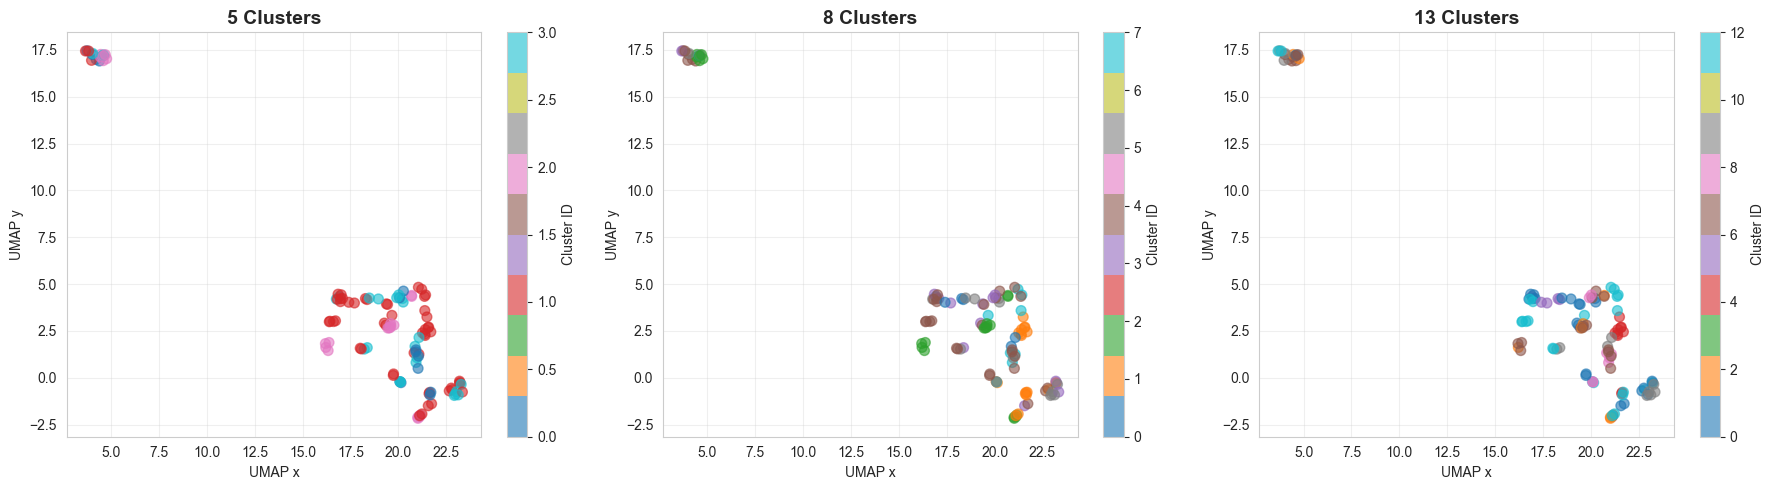


💡 Tip: Choose the number of clusters based on your analysis goals.
   - Fewer clusters: Broader categories
   - More clusters: Finer-grained distinctions


In [40]:
# Visualize clusters on UMAP projection
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, n_clusters in zip(axes, cluster_configs):
    col_name = f'cluster_{n_clusters:02d}'
    
    scatter = ax.scatter(
        demo_df['x_umap'],
        demo_df['y_umap'],
        c=demo_df[col_name],
        cmap='tab10',
        alpha=0.6,
        s=50
    )
    
    ax.set_title(f'{n_clusters} Clusters', fontsize=14, fontweight='bold')
    ax.set_xlabel('UMAP x')
    ax.set_ylabel('UMAP y')
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Cluster ID')

plt.tight_layout()
plt.show()

print("\n💡 Tip: Choose the number of clusters based on your analysis goals.")
print("   - Fewer clusters: Broader categories")
print("   - More clusters: Finer-grained distinctions")

### Cosmograph

In [42]:
from cosmograph import cosmo

g2 = cosmo(
    demo_df,
    point_x_by='x_umap',
    point_y_by='y_umap',
    point_label_by='conversation.content',
    point_color_by='cluster_13',
)
g2


Cosmograph(background_color=None, components_display_state_mode=None, focused_point_ring_color=None, hovered_p…

## Step 7: Prepare Final Visualization-Ready DataFrame

Now we have everything needed for rich visualizations:

- ✅ **x, y coordinates** (multiple methods: UMAP, t-SNE, PCA)
- ✅ **Color encodings** (cluster assignments at different granularities)
- ✅ **Size encodings** (segment length, token count)
- ✅ **Metadata** (role, language, toxicity scores, etc.)

### What to Include

For each point in your visualization, consider:
1. **Position** (x, y) - from planarization
2. **Color** - clusters, categories, or continuous values
3. **Size** - importance, length, or other metrics
4. **Hover info** - text preview, detailed metadata
5. **IDs** - for linking back to original data

In [44]:
# Select the columns we want in our final visualization dataset
viz_columns = [
    # Identifiers
    'segment_id',
    'conversation_hash',
    
    # The text itself
    'conversation.content',
    
    # Metadata
    'conversation.role',
    'language',
    'segment_length',
    # 'n_tokens',
    
    # Coordinates (choose your preferred method)
    'x_umap', 'y_umap',
    'x_tsne', 'y_tsne', 
    'x_pca', 'y_pca',
    
    # Cluster assignments
    'cluster_05',
    'cluster_08',
    'cluster_13',
]

# Create the final DataFrame
viz_ready_df = demo_df[viz_columns].copy()

print(f"Visualization-ready dataset: {viz_ready_df.shape}")
print(f"Columns: {viz_ready_df.columns.tolist()}")

Visualization-ready dataset: (200, 15)
Columns: ['segment_id', 'conversation_hash', 'conversation.content', 'conversation.role', 'language', 'segment_length', 'x_umap', 'y_umap', 'x_tsne', 'y_tsne', 'x_pca', 'y_pca', 'cluster_05', 'cluster_08', 'cluster_13']


In [45]:
# Preview the final data
viz_ready_df.head()

,segment_id,conversation_hash,conversation.content,conversation.role,language,segment_length,x_umap,y_umap,x_tsne,y_tsne,x_pca,y_pca,cluster_05,cluster_08,cluster_13
0,0,c9ec5b440fbdd2a269333dd241f32f64,Hey there! Are you familiar with reality shift...,user,English,1373,23.231699,-0.276132,-5.889598,-11.294784,-9.410599,-12.733225,1,3,1
1,1,c9ec5b440fbdd2a269333dd241f32f64,Hey there! I'm more than happy to help you pla...,assistant,English,3069,22.657951,-0.697300,-3.166571,-9.552048,-7.494258,-8.685440,1,4,1
6,6,cf1267ca6b2f6fccc9c36652a00059a1,"Old age PT hx of DM, HTN, dyslipidemia His ECG...",user,English,115,23.195763,-0.262428,-4.289722,-11.723392,-9.575293,-12.943953,1,1,12
7,7,cf1267ca6b2f6fccc9c36652a00059a1,The highest risk factor for this condition (my...,assistant,English,326,22.809317,-0.632842,-3.910643,-10.357627,-9.062532,-11.267789,1,1,12
10,10,e98d3e74c57f9a65261df393d9124ac2,Hey there! Are you familiar with reality shift...,user,English,1428,23.194490,-0.180666,-5.190506,-11.902749,-9.258605,-12.956757,1,3,1


## Step 8: Save for Visualization Tools

Now save the prepared data in formats suitable for various visualization tools.

In [ ]:
# Save as CSV (for most tools)
csv_path = 'wildchat_viz_ready.csv'
viz_ready_df.to_csv(csv_path, index=False)
print(f"Saved to {csv_path}")

# Save as Parquet (more efficient for large datasets)
parquet_path = 'wildchat_viz_ready.parquet'
viz_ready_df.to_parquet(parquet_path, index=False)
print(f"Saved to {parquet_path}")

# If you want to keep the embeddings too (for further analysis)
full_path = 'wildchat_with_embeddings.parquet'
demo_df.to_parquet(full_path, index=False)
print(f"Saved full dataset (with embeddings) to {full_path}")

## Example: Basic Interactive Visualization

Let's create a simple interactive plot to verify our data is ready.

In [48]:
# Create an interactive plot with role colors
import plotly.express as px

fig = px.scatter(
    viz_ready_df,
    x='x_umap',
    y='y_umap',
    color='conversation.role',
    size='segment_length',
    hover_data={
        'conversation.content': True,
        'conversation.role': True,
    },
    title='WildChat Conversations: UMAP Projection',
    labels={
        'x_umap': 'UMAP Dimension 1',
        'y_umap': 'UMAP Dimension 2',
        'conversation.role': 'Role'
    },
    width=900,
    height=600
)

fig.update_traces(marker=dict(opacity=0.7))
fig.show()

print("\n✅ Interactive visualization created!")
print("Hover over points to see the conversation content and metadata.")


✅ Interactive visualization created!
Hover over points to see the conversation content and metadata.


## Summary: The Complete Pipeline

We've walked through the complete process:

### 1. Data Loading & Exploration
- Loaded WildChat from HuggingFace
- Understood the nested structure

### 2. Segmentation
- Expanded nested conversations into individual turns
- Each turn became a segment for embedding

### 3. Filtering & Validation  
- Filtered to English
- Validated token counts
- Kept only complete, valid conversations

### 4. Embedding Computation
- Converted text to 1536-dimensional vectors
- Used OpenAI's text-embedding-3-small model

### 5. Planarization
- Reduced to 2D with UMAP, t-SNE, and PCA
- Preserved semantic relationships

### 6. Clustering
- Grouped similar segments
- Created cluster labels for coloring

### 7. Data Preparation
- Assembled visualization-ready DataFrame
- Included coordinates, clusters, and metadata

### 8. Export & Visualization
- Saved in multiple formats
- Created example interactive plot

---

## Key Takeaways

### General Principles (Apply to Any Dataset)

1. **Segmentation matters**: Choose the right granularity for your analysis
2. **Filter early**: Remove invalid segments before expensive operations
3. **High-dim embeddings first**: Cluster and analyze in full space
4. **Multiple planarizations**: Try several methods, compare results
5. **Rich metadata**: Include everything useful for analysis and hover info

### Dataset-Specific Decisions (WildChat)

1. **Expand nested structure**: Flatten conversations into turns
2. **Language filtering**: Focus on English for consistency  
3. **Conversation integrity**: Keep only complete conversations
4. **Role information**: Distinguish user vs assistant segments

---

## Next Steps

From here, you can:
- **Scale up**: Process the full 1M conversation dataset
- **Advanced visualization**: Use Plotly Dash, Bokeh, or custom web viz
- **Cluster analysis**: Examine what each cluster represents semantically
- **Topic modeling**: Add another dimension with LDA or BERTopic
- **Time series**: Explore how conversations evolve over time
- **Comparative analysis**: Compare different subsets (languages, toxicity levels, etc.)

---

## Additional Resources

- **imbed package**: [Documentation link]
- **UMAP guide**: Understanding UMAP parameters
- **Embedding models**: Comparison of different options
- **Visualization libraries**: Plotly, Bokeh, D3.js guides